# EBAC - Regressão II - regressão múltipla

## Tarefa I

### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [2]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

import numpy as np
import pandas as pd
import patsy

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/content/sample_data/previsao_de_renda.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

==============================================================================================================

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

==============================================================================================================

In [5]:
# Preparando os dados
df.drop(columns=['Unnamed: 0', 'data_ref', 'id_cliente'], inplace=True)

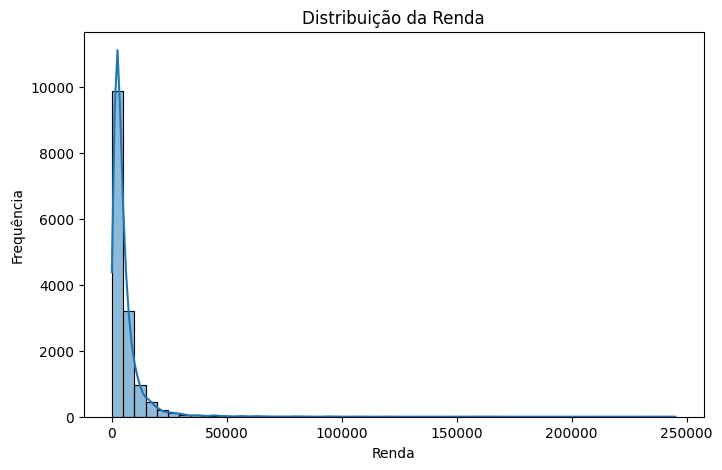

In [6]:
# Analisando a distribuição da variável alvo

plt.figure(figsize=(8, 5))
sns.histplot(df['renda'], bins=50, kde=True)
plt.title('Distribuição da Renda')
plt.xlabel('Renda')
plt.ylabel('Frequência')
plt.show()


In [7]:
# Verificando valores nulos

print(df.isnull().sum())

sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            2573
qt_pessoas_residencia       0
renda                       0
dtype: int64


In [8]:
# Inputando registros com a média móvel onde tempo_emprego é nulo

df_otimizado = df.copy()
df_otimizado['tempo_emprego'] = df_otimizado['tempo_emprego'].interpolate(method='linear')

In [9]:
df_otimizado.isna().sum()

sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

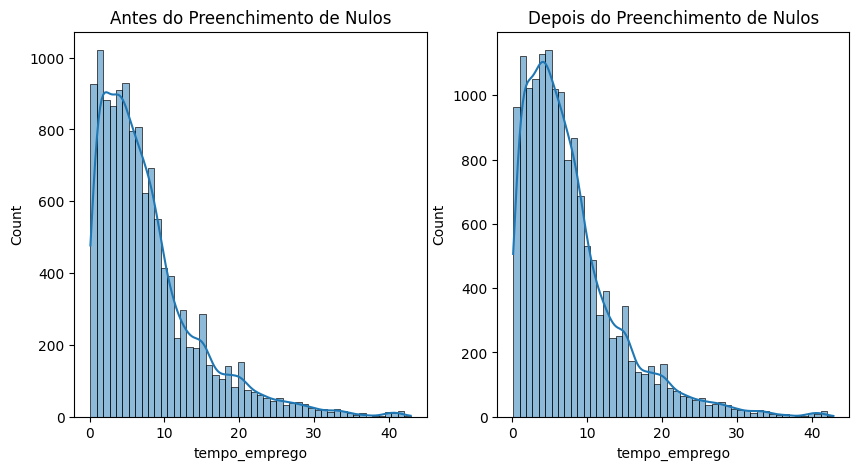

In [10]:
# Observando a distribuição de 'tempo_emprego' antes e depois da inputação de valores

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['tempo_emprego'], bins=50, kde=True)
plt.title('Antes do Preenchimento de Nulos')

plt.subplot(1, 2, 2)
sns.histplot(df_otimizado['tempo_emprego'], bins=50, kde=True)
plt.title('Depois do Preenchimento de Nulos')

plt.show()


In [11]:
# Separando as variáveis explicativas (X) e a variável alvo (y)

X = df_otimizado.drop(columns=['renda'])
y = df_otimizado['renda']

In [12]:
print(X.isnull().sum())

sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
dtype: int64


In [21]:
#=================================================================================
# 1) Separe a base em treinamento e teste (25% para teste, 75% para treinamento)
#=================================================================================

# Transformando categorias em dummies
X = pd.get_dummies(X, drop_first=True)

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [22]:
# Normalizando os dados

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


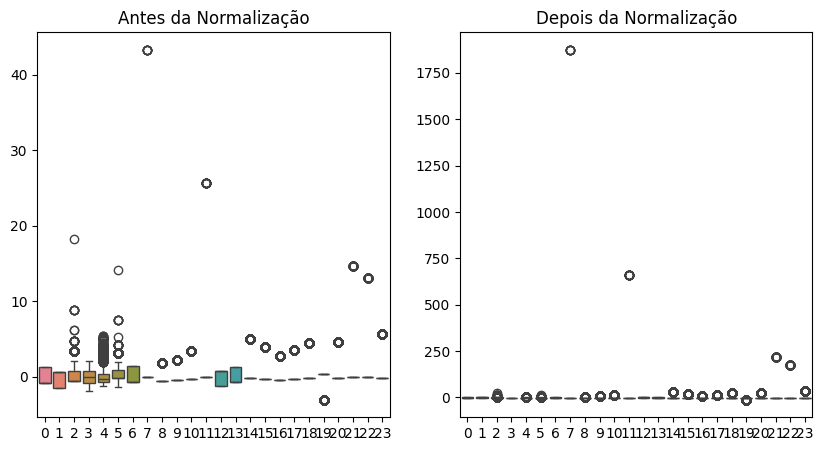

In [23]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=X_train)
plt.title('Antes da Normalização')

plt.subplot(1, 2, 2)
sns.boxplot(data=scaler.transform(X_train))
plt.title('Depois da Normalização')

plt.show()


In [24]:
#=========================================================================================================================================
# 2) Rode uma regularização ridge com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o  R2  na base de testes. Qual o melhor modelo?
#=========================================================================================================================================

# Testando diferentes valores de alpha
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100,1000,10000]
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f'Alpha: {alpha} | R²: {r2:.6}')

Alpha: 0 | R²: 0.251327
Alpha: 0.001 | R²: 0.251327
Alpha: 0.005 | R²: 0.251327
Alpha: 0.01 | R²: 0.251327
Alpha: 0.05 | R²: 0.251327
Alpha: 0.1 | R²: 0.251327
Alpha: 1 | R²: 0.251325
Alpha: 10 | R²: 0.251306
Alpha: 100 | R²: 0.25112
Alpha: 1000 | R²: 0.247989
Alpha: 10000 | R²: 0.18742


In [25]:
#====================================================================================================
# 3) Faça o mesmo que no passo 2, com uma regressão LASSO. Qual método chega a um melhor resultado?
#====================================================================================================

# Treinar o modelo LASSO
lasso = Lasso(alpha=100)  # Você pode experimentar diferentes valores de alpha
lasso.fit(X_train, y_train)

# Fazer previsões e calcular R²
y_pred_lasso = lasso.predict(X_test)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'R² do modelo Ridge: {r2:.4}')
print(f'R² do modelo LASSO: {r2_lasso:.4f}')



R² do modelo Ridge: 0.1874
R² do modelo LASSO: 0.2481


In [27]:
#========================================================================================
# 4) Rode um modelo stepwise. Avalie o  R2  na vase de testes. Qual o melhor resultado?
#========================================================================================

# 1. Criar o modelo stepwise
sfs = SequentialFeatureSelector(LinearRegression(),
                              k_features='best',
                              forward=True,
                              scoring='r2',
                              cv=5,
                              n_jobs=-1)  # usa todos os processadores

# 2. Ajustar o modelo aos dados de treino
sfs = sfs.fit(X_train, y_train)

# 3. Obter as features selecionadas
selected_features = X.columns[list(sfs.k_feature_idx_)]
print('a. Variáveis selecionadas:', list(selected_features))

# 4. Criar um modelo apenas com as features selecionadas
model = LinearRegression()
model.fit(X_train[:, sfs.k_feature_idx_], y_train)

# 5. Avaliar na base de teste
y_pred = model.predict(X_test[:, sfs.k_feature_idx_])
r2 = r2_score(y_test, y_pred)

# 6. Mostrar estatísticas detalhadas
print(f'\nb.Número de features selecionadas: {len(selected_features)}')
print(f'c. Features selecionadas: {list(selected_features)}')
print(f'd. Score R² no treino: {sfs.k_score_:.4f}')
print(f'e. Score R² no teste: {r2:.4f}')
print('\n')
print(f'O melhor resultado de R² é o de Ridge')

a. Variáveis selecionadas: ['posse_de_imovel', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'sexo_M', 'tipo_renda_Empresário', 'tipo_renda_Pensionista', 'educacao_Superior completo', 'educacao_Superior incompleto', 'estado_civil_Solteiro', 'estado_civil_União']

b.Número de features selecionadas: 11
c. Features selecionadas: ['posse_de_imovel', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'sexo_M', 'tipo_renda_Empresário', 'tipo_renda_Pensionista', 'educacao_Superior completo', 'educacao_Superior incompleto', 'estado_civil_Solteiro', 'estado_civil_União']
d. Score R² no treino: 0.2420
e. Score R² no teste: 0.2517


O melhor resultado de R² é o de Ridge


##5) Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?

## Interpretando os resultados: R² de cada teste:

| Lasso                 | Ridge                 |Stepwise                 |
| --------------------- | --------------------- | ---------------------   |
| 0.2481                | 0.2690                | 0.2690                  |


## R: O melhor modelo é o Stepwise, devido a alta interpretabilidade.

In [28]:
# =================================================================================================================================================================================
# 6) Partindo dos modelos que você ajustou, tente melhorar o  R2  na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
# =================================================================================================================================================================================

# Aplicando log na variável alvo
y_log = np.log(y)

# Dividindo novamente em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.25, random_state=42)

# Treinando a regressão linear com log(y)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_log = lr_model.predict(X_test)

# Avaliando o modelo
r2_log = r2_score(y_test, y_pred_log)
print(f'R² com log(y): {r2_log:.4f}')


R² com log(y): 0.3314


In [29]:
X['idade_tempo_emprego'] = X['idade'] * X['tempo_emprego']

# Criando uma nova divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.25, random_state=42)

# Treinando o modelo novamente
lr_model.fit(X_train, y_train)
y_pred_interacao = lr_model.predict(X_test)

# Avaliando o impacto da nova feature
r2_interacao = r2_score(y_test, y_pred_interacao)
print(f'R² com interação idade * tempo_emprego: {r2_interacao:.4f}')


R² com interação idade * tempo_emprego: 0.3393


In [32]:
# ============================================================================
# Ajuste uma árvore de regressão e veja se consegue um R² melhor com ela.
# ============================================================================

# Criando o modelo de árvore de decisão
tree_model = DecisionTreeRegressor(random_state=42)

# Treinando a árvore com os dados
tree_model.fit(X_train, y_train)

# Fazendo previsões
y_pred_tree = tree_model.predict(X_test)

# Avaliando o modelo
r2_tree = r2_score(y_test, y_pred_tree)
print(f'R² da Árvore de Regressão: {r2_tree:.4f}')


R² da Árvore de Regressão: 0.2121


In [33]:
# Analisando a árvore

print('Profundidade da Árvore de Regressão:')
for depth in [3, 5, 7, 10, None]:  # None = árvore sem limite de profundidade
    tree_model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_model.fit(X_train, y_train)
    y_pred_tree = tree_model.predict(X_test)
    r2_tree = r2_score(y_test, y_pred_tree)
    print(f'Profundidade {depth} | R²: {r2_tree:.4f}')


Profundidade da Árvore de Regressão:
Profundidade 3 | R²: 0.3178
Profundidade 5 | R²: 0.3450
Profundidade 7 | R²: 0.3571
Profundidade 10 | R²: 0.3291
Profundidade None | R²: 0.2121
